<a href="https://colab.research.google.com/github/redswimmer/impact-investment-analysis-yc-summer-cohort-2023/blob/main/VIII_for_YC_Cohort_Summer_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VIII for YC Cohort Summer 2023

I decided to experiment with the dataset provided in the article by Brandon Lopez, titled "[Impact Investment Preliminary Analysis of Y Combinator Summer Cohort 2023](https://www.valleyinnovators.com/post/impact-investment-preliminary-analysis-of-y-combinator-summer-cohort-2023)". In this study, Brandon scrutinizes 25 of the startups accepted into Y-Combinator, assigning them a Valley Innovators Impact Index (VIII). The VIII is a weighted formula used to evaluate the potential of a startup for impact investors, and it is calculated as VIII = societal impact x societal reach x time to impact. I wanted to explore how accurately I could reverse-engineer the formula by using a linear regression model trained on the features mentioned in the article. For a playful twist, I also added a few new elements (up votes and hashtags) from the startups' bio pages on the YC site.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

## Data loading

In [3]:
df = pd.read_csv('viii_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Startup                          25 non-null     object
 1   Value Prop                       25 non-null     object
 2   Source                           25 non-null     object
 3   Societal Impact                  25 non-null     int64 
 4   Societal Reach                   25 non-null     int64 
 5   Time to Impact                   25 non-null     int64 
 6   Up Votes                         25 non-null     int64 
 7   Tags                             25 non-null     object
 8   Valley Innovators Impact Index*  25 non-null     int64 
dtypes: int64(5), object(4)
memory usage: 1.9+ KB


In [4]:
df.head()

,Startup,Value Prop,Source,Societal Impact,Societal Reach,Time to Impact,Up Votes,Tags,Valley Innovators Impact Index*
0,Kite,Software marketing videos made easy-breezy,https://www.ycombinator.com/launches/JGE-kite-...,1,3,7,22,#ai#video#media#marketing#advertising,21
1,Khoj,Open Source AI Assistant,https://www.ycombinator.com/launches/JG4-khoj-...,3,7,3,34,#ai#consumer#open_source#ai_assistant#generati...,63
2,Truemetrics,Improve logistics delivery efficiency,https://www.ycombinator.com/launches/JFo-truem...,5,7,5,15,#ai,175
3,Synaptiq,AI-powered medical training platform,https://www.ycombinator.com/launches/JFk-synap...,9,9,5,22,#education#healthcare#artificial_intelligence,405
4,Telophase,clone your AWS environments,https://www.ycombinator.com/launches/JFi-telop...,3,5,3,26,#b2b#infrastructure#developer_tools,45


### Data description

This data is the first 25 startups from YCs website under [batch S2023](https://www.ycombinator.com/launches?batch=S2023). The columns that we are interested are:
- **Startup**: Name of the startup
- **Value Prop**: A text description of the value proposition
- **Source**: Link to the startup on YC
- **Societal Impact**: Societal impact means can the business change our lives significantly for the better, as a collective society.  Scale of 1-10 for each variable with 1 being lowest impact and 10 being highest impact.
- **Societal Reach**: Societal reach means how may people on the planet can benefit from this core business idea. Scale of 1-10 for each variable with 1 being lowest impact and 10 being highest impact.
- **Time to Impact**: Time to impact means how long can we estimate it to take for significant impact to be achieved. Scale of 1-10 for each variable with 1 being lowest impact and 10 being highest impact.
- **Up Votes**: Startup upvotes on YC
- **Valley Innovators Impact Index**: Valley Innovators Impact Index (VIII) is a weighted formula for evaluating the potential of a startup for impact investors.  VIII = societal impact x societal reach x time to impact

## Data cleaning

### Drop columns we're not interested in

In [5]:
df = df.drop(df.iloc[:, :3], axis=1)
df.head()

,Societal Impact,Societal Reach,Time to Impact,Up Votes,Tags,Valley Innovators Impact Index*
0,1,3,7,22,#ai#video#media#marketing#advertising,21
1,3,7,3,34,#ai#consumer#open_source#ai_assistant#generati...,63
2,5,7,5,15,#ai,175
3,9,9,5,22,#education#healthcare#artificial_intelligence,405
4,3,5,3,26,#b2b#infrastructure#developer_tools,45


### Rename "Valley Innovators Impact Index*" to "viii"

In [6]:
df = df.rename(columns={'Valley Innovators Impact Index*': 'viii'})
df.columns

Index(['Societal Impact', 'Societal Reach', 'Time to Impact', 'Up Votes',
       'Tags', 'viii'],
      dtype='object')

### Rename the columns to be all lowercase, replace spaces with underscores ("_") and make sure there are no spaces at the start or finish of a column name.

In [7]:
df.columns = [x.lower().strip().replace(' ', '_') for x in df.columns]
df.columns

Index(['societal_impact', 'societal_reach', 'time_to_impact', 'up_votes',
       'tags', 'viii'],
      dtype='object')

### Change floats to ints

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   societal_impact  25 non-null     int64 
 1   societal_reach   25 non-null     int64 
 2   time_to_impact   25 non-null     int64 
 3   up_votes         25 non-null     int64 
 4   tags             25 non-null     object
 5   viii             25 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.3+ KB


In [9]:
for col in df.columns:
  if (df[col].dtype == 'float64'):
    print(f'{col}')
    df[col] = df[col].astype('int')

### Sanity check

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   societal_impact  25 non-null     int64 
 1   societal_reach   25 non-null     int64 
 2   time_to_impact   25 non-null     int64 
 3   up_votes         25 non-null     int64 
 4   tags             25 non-null     object
 5   viii             25 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.3+ KB


### Check for missing values

In [11]:
df[df.columns].isna().sum()

societal_impact    0
societal_reach     0
time_to_impact     0
up_votes           0
tags               0
viii               0
dtype: int64

## Encoding categorical data

### Split hashtags string into categorical features and remove tags column

In [12]:
df = pd.concat([df, df['tags'].str.get_dummies(sep='#').add_prefix('tag_')], axis = 1).drop(['tags'], axis=1)
df.columns

Index(['societal_impact', 'societal_reach', 'time_to_impact', 'up_votes',
       'viii', 'tag_advertising', 'tag_agriculture', 'tag_ai',
       'tag_ai_assistant', 'tag_aiops', 'tag_analytics',
       'tag_artificial_intelligence', 'tag_automation', 'tag_b2b',
       'tag_big_data', 'tag_biotech', 'tag_chatbot', 'tag_climate',
       'tag_compliance', 'tag_computer_vision', 'tag_consumer',
       'tag_consumer_finance', 'tag_consumer_health_services',
       'tag_data_engineering', 'tag_data_science', 'tag_data_visualization',
       'tag_developer_tools', 'tag_diagnostics', 'tag_digital_health',
       'tag_education', 'tag_emerging_markets', 'tag_enterprise',
       'tag_enterprise_software', 'tag_femtech', 'tag_fintech',
       'tag_generative_ai', 'tag_genomics', 'tag_health_tech',
       'tag_healthcare', 'tag_healthcare_it', 'tag_india',
       'tag_infrastructure', 'tag_machine_learning', 'tag_marketing',
       'tag_marketplace', 'tag_media', 'tag_open_source', 'tag_operations'

### Move VIII to last column

In [13]:
new_cols = [col for col in df.columns if col != 'viii'] + ['viii']
df = df[new_cols]
df.columns

Index(['societal_impact', 'societal_reach', 'time_to_impact', 'up_votes',
       'tag_advertising', 'tag_agriculture', 'tag_ai', 'tag_ai_assistant',
       'tag_aiops', 'tag_analytics', 'tag_artificial_intelligence',
       'tag_automation', 'tag_b2b', 'tag_big_data', 'tag_biotech',
       'tag_chatbot', 'tag_climate', 'tag_compliance', 'tag_computer_vision',
       'tag_consumer', 'tag_consumer_finance', 'tag_consumer_health_services',
       'tag_data_engineering', 'tag_data_science', 'tag_data_visualization',
       'tag_developer_tools', 'tag_diagnostics', 'tag_digital_health',
       'tag_education', 'tag_emerging_markets', 'tag_enterprise',
       'tag_enterprise_software', 'tag_femtech', 'tag_fintech',
       'tag_generative_ai', 'tag_genomics', 'tag_health_tech',
       'tag_healthcare', 'tag_healthcare_it', 'tag_india',
       'tag_infrastructure', 'tag_machine_learning', 'tag_marketing',
       'tag_marketplace', 'tag_media', 'tag_open_source', 'tag_operations',
       'tag_p

## Data Exploration

### Lets examine the shape of the data distribution

In [14]:
def histVIII(col, desc):
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.hist(df[col], bins=5)
  ax.set(title=f'{desc}', xlabel=desc)
  ax.set_xlim(1, 10)

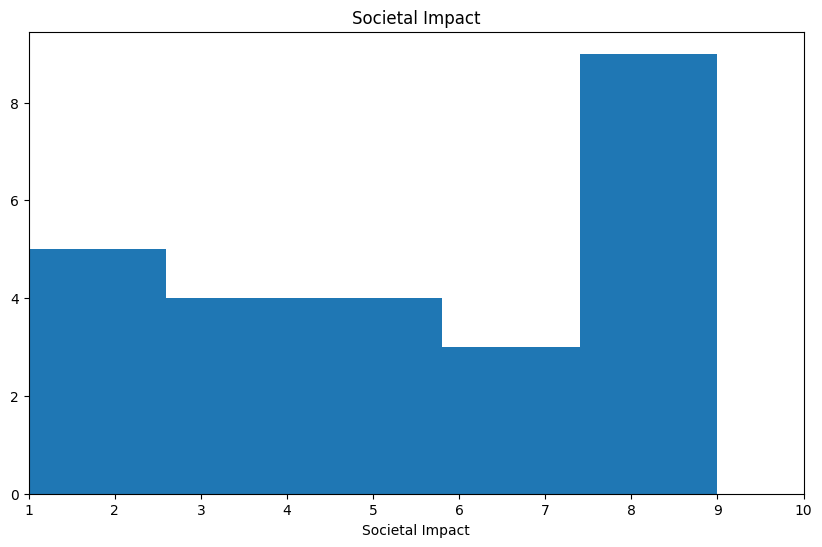

In [15]:
histVIII('societal_impact', 'Societal Impact')

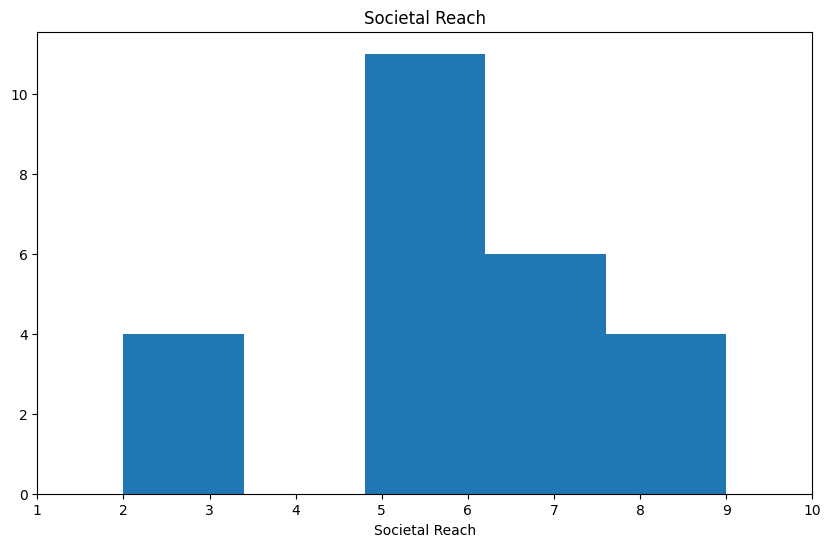

In [16]:
histVIII('societal_reach', 'Societal Reach')

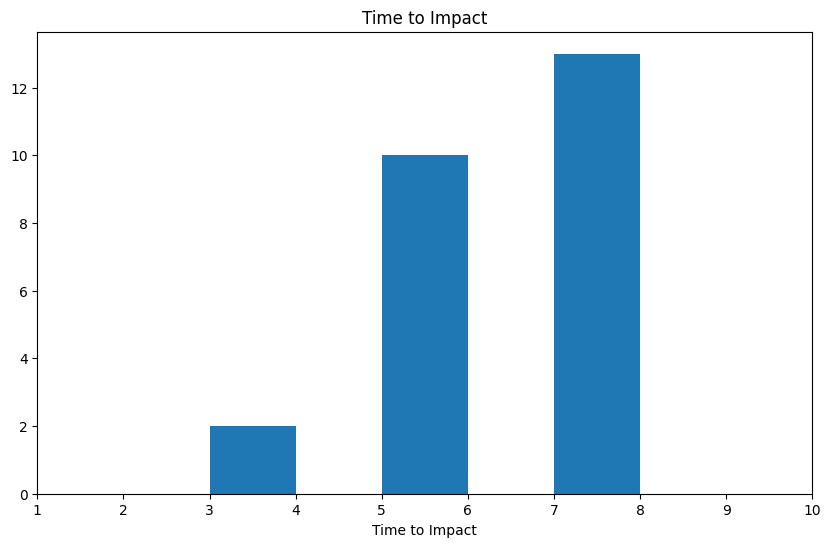

In [17]:
histVIII('time_to_impact', 'Time to Impact')

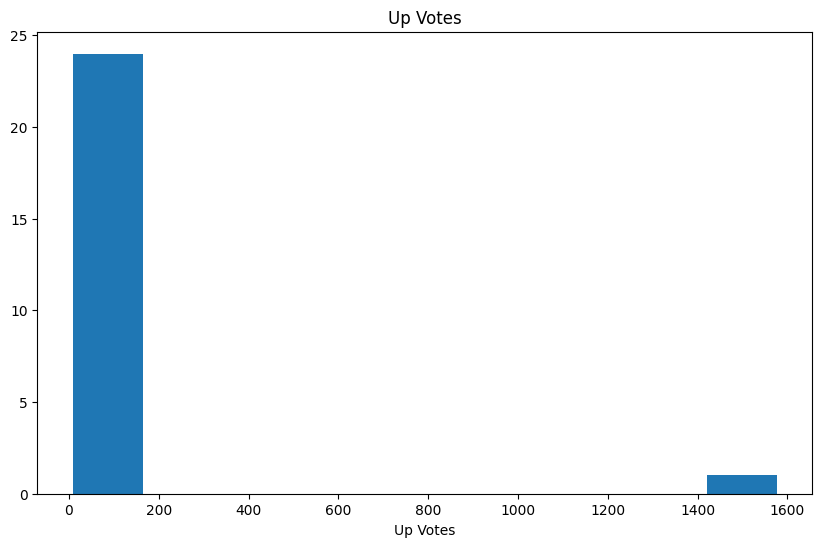

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df['up_votes'], bins=10)
ax.set(title='Up Votes', xlabel='Up Votes');

We have one outlier.  Lets drop that and replot to get a better idea of what our up votes really look like.

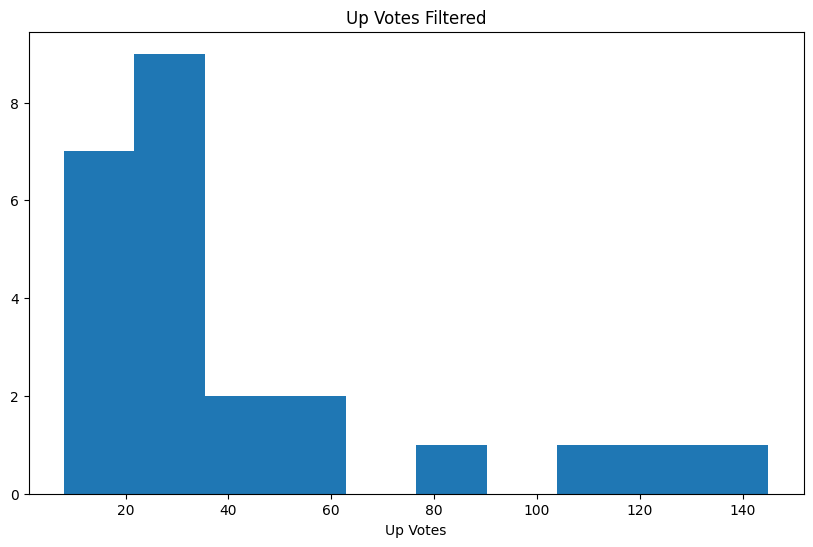

In [19]:
# Drop our up votes outlier
df_filtered = df[df['up_votes'] <= 1000]

# Plot again
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_filtered['up_votes'], bins=10)
ax.set(title='Up Votes Filtered', xlabel='Up Votes');

### How well does the continuous numerical columns correlate to the VIII?

In [20]:
# The integers are societal_impact, societal_reach, time_to_impact, up_votes and viii (tags are really categorical)
cont_cols = ['societal_impact', 'societal_reach', 'time_to_impact', 'up_votes', 'viii']
cont_df = df[cont_cols]
cont_df.corr()

,societal_impact,societal_reach,time_to_impact,up_votes,viii
societal_impact,1.000000,0.711795,-0.020507,0.042264,0.927325
societal_reach,0.711795,1.000000,-0.284758,-0.058066,0.775497
time_to_impact,-0.020507,-0.284758,1.000000,-0.154529,0.181378
up_votes,0.042264,-0.058066,-0.154529,1.000000,-0.070160
viii,0.927325,0.775497,0.181378,-0.070160,1.000000


The feature with the strongest correlation to viii is 'societal_impact' at 93%, followed by 'societal_reach' at 78% followed by 'time_to_impact' at 18% and finally followed by 'up_votes' at -7%.

### Lets plot each of these columns in relation to the VIII

In [21]:
# Create a function to save time
def plotVIII(col, desc):
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.scatter(df[col], df['viii'])
  ax.grid()
  ax.set(title=f'{desc} vs VIII (R2 = {np.corrcoef(df[col], df["viii"])[0, 1]**2:.3})', xlabel=desc, ylabel='VIII')

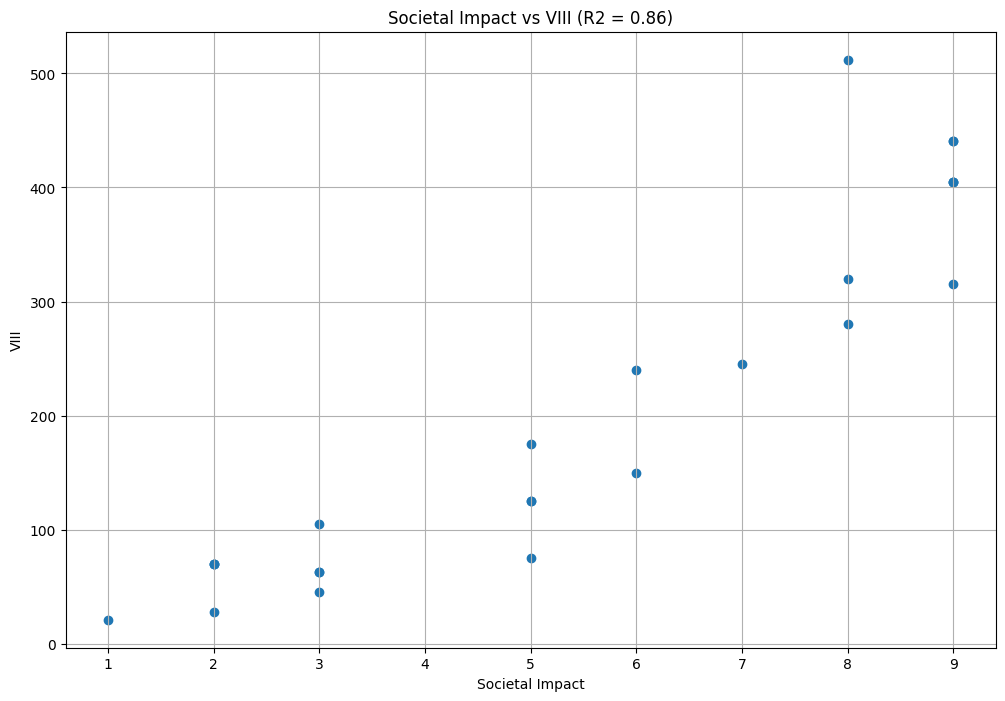

In [22]:
plotVIII('societal_impact', 'Societal Impact')

The above plot suggests a strong positive correlation between societal impact and viii

In [23]:
# Compute the correlation coefficient between societal_impact to viii
np.corrcoef(cont_df['societal_impact'], cont_df['viii'])[0,1]**2

0.8599311360121324

The correlation between societal_impact and viii is 0.8599 so aproximentally 86% of the variation in the viii is determined by the societal_impact.

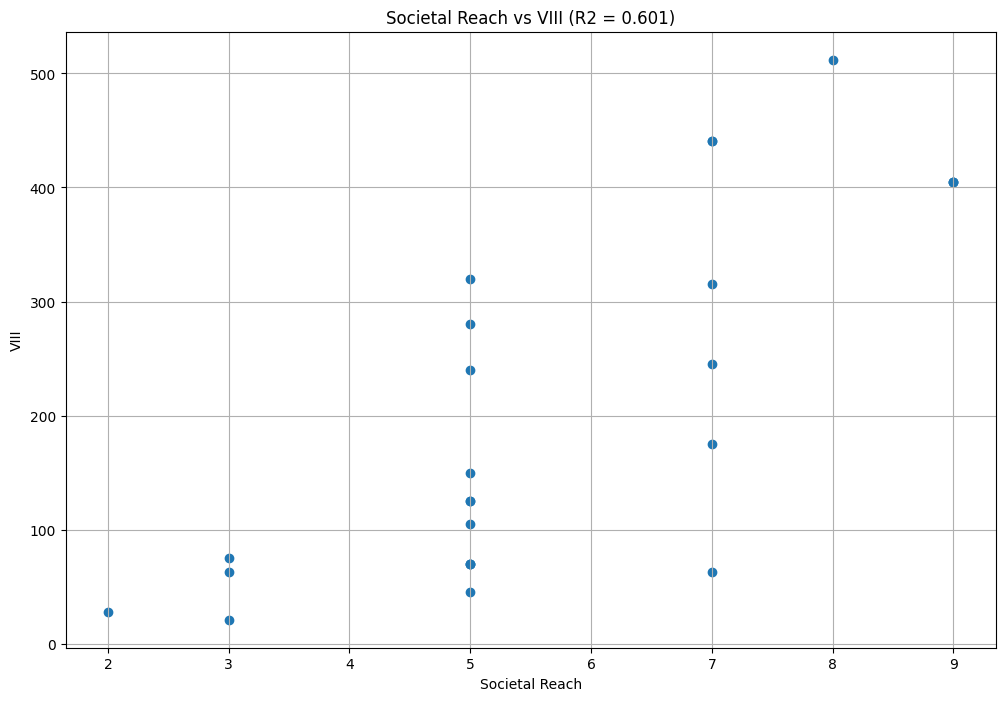

In [24]:
plotVIII('societal_reach', 'Societal Reach')

The above plot suggests a positive correlation between societal reach and viii

In [25]:
# Compute the correlation coefficient between societal_reach to viii
np.corrcoef(cont_df['societal_reach'], cont_df['viii'])[0,1]**2

0.6013959037275913

The correlation between societal reach and viii is 0.6014 so aproximentally 60% of the variation in the viii is determined by the societal reach.

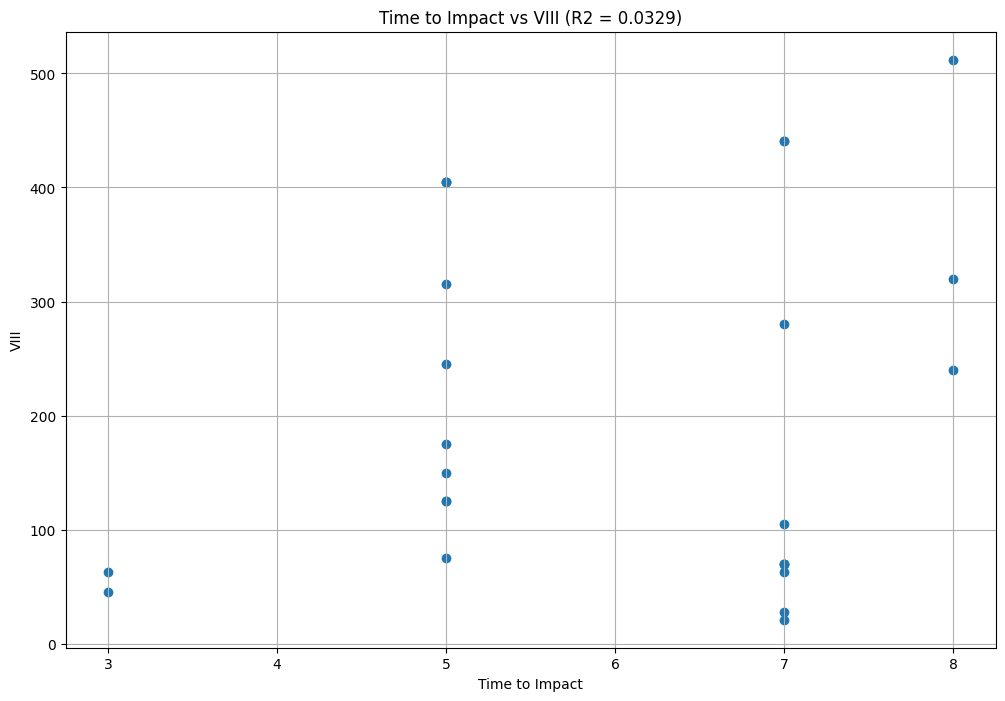

In [26]:
plotVIII('time_to_impact', 'Time to Impact')

The above plot suggests a weak positive correlation between time to impact and viii

In [27]:
# Compute the correlation coefficient between time_to_impact to viii
np.corrcoef(cont_df['time_to_impact'], cont_df['viii'])[0,1]**2

0.03289815060705503

The correlation between time to impact and viii is 0.0328 so aproximentally 3% of the variation in the viii is determined by the time to impact.

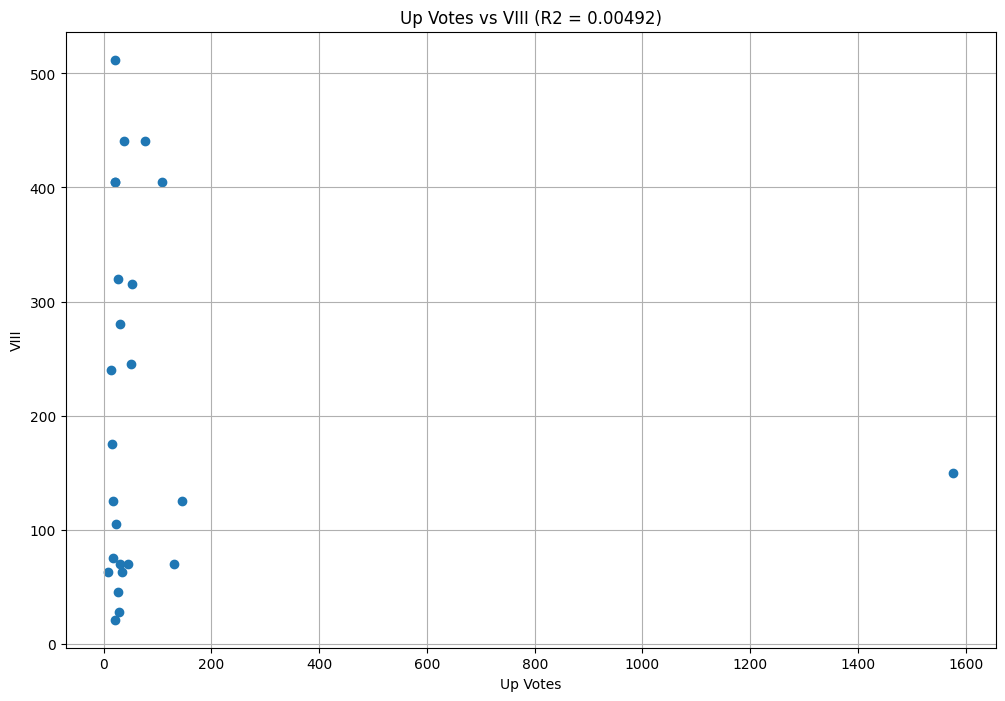

In [28]:
plotVIII('up_votes', 'Up Votes')

The above plot suggests no significant correlation between up votes and viii

In [29]:
# Compute the correlation coefficient between time_to_impact to viii
np.corrcoef(cont_df['up_votes'], cont_df['viii'])[0,1]**2

0.004922418607736081

The correlation between time to impact and viii is 0.0049 so less than 1% of the variation in the viii is determined by the up votes.

In [30]:
# Display R2 scores in one place to summarize
for col in cont_cols:
  if (col != 'viii'):
    r2 = np.corrcoef(cont_df[col], cont_df["viii"])[0, 1]**2
    print(f'{col} R^2 = {r2:.3}')

societal_impact R^2 = 0.86
societal_reach R^2 = 0.601
time_to_impact R^2 = 0.0329
up_votes R^2 = 0.00492


In summmary, Societal Impact has the strongest correlation to VIII of 86%, followed by the Societal Reach at 60%, followed by Time to Impact at 3% and finally Up Votes at <1%

### Examining Tag Popularity

In [31]:
# Get tag columns
tag_cols = [col for col in df.columns if col.startswith('tag_')]
tag_df = df[tag_cols]

tags = {}
for col in tag_df.columns:
  tags[col.replace('tag_', '')] = df[col].sum()

tag_df = pd.DataFrame(tags.items(), columns=['Tag', 'Total']).sort_values(by='Total', ascending=True)

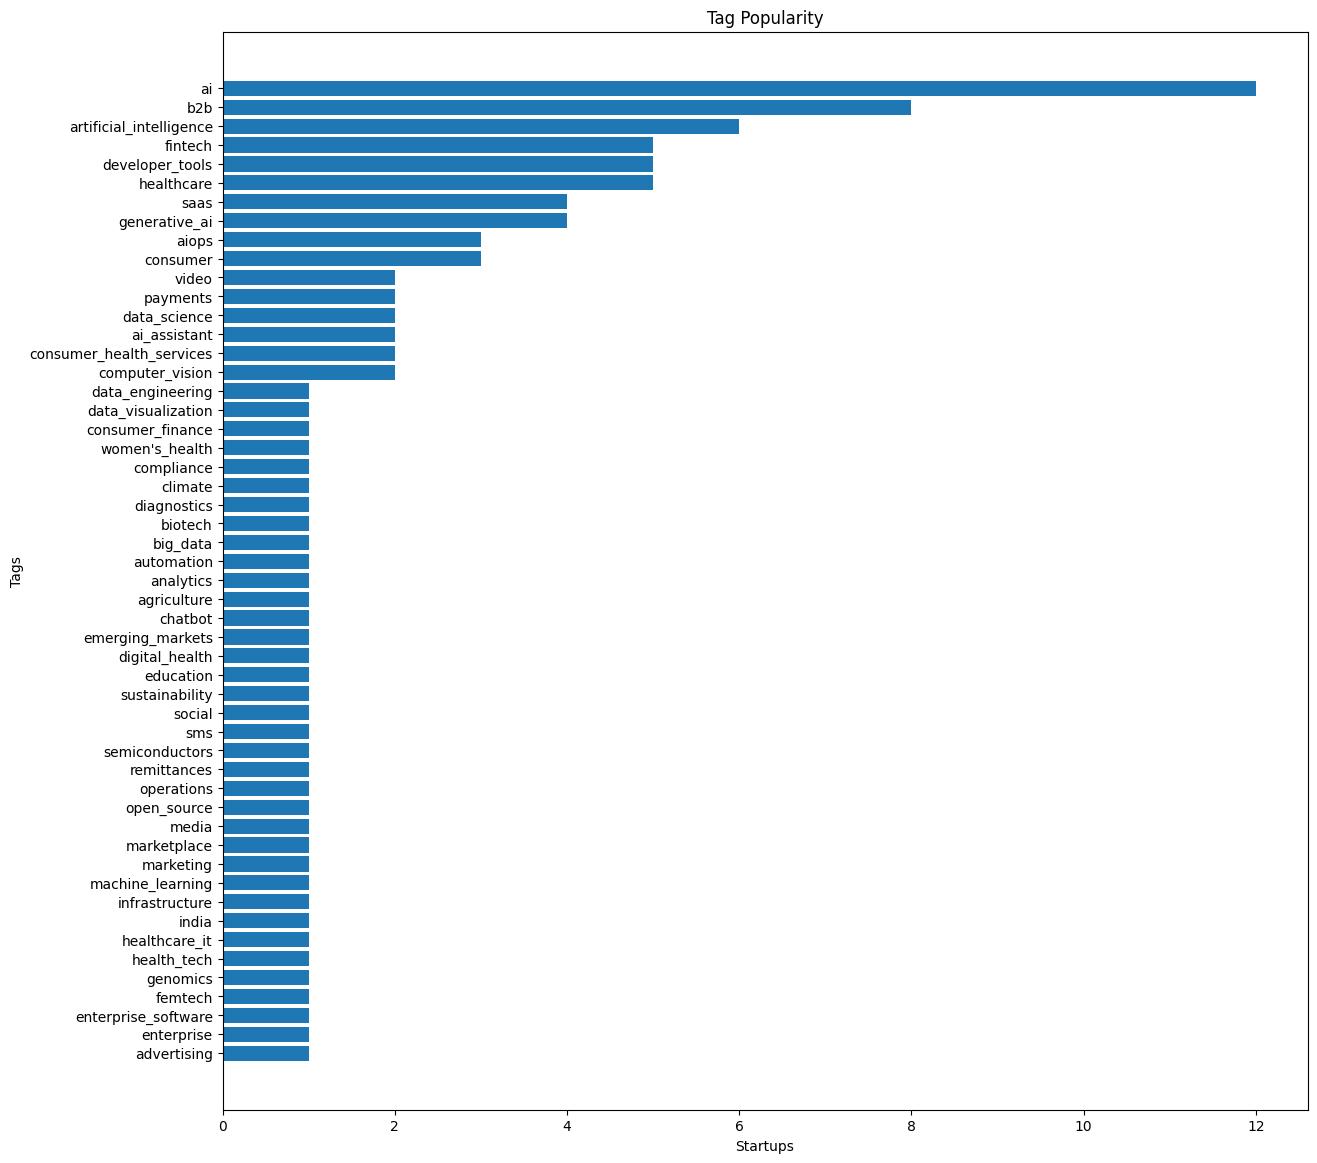

In [32]:
# Make a bar plot comparing the most popular tags
fig, ax = plt.subplots(figsize=(14, 14))
ax.barh(tag_df['Tag'], tag_df['Total'])
ax.set(xlabel='Startups', ylabel='Tags', title='Tag Popularity');

As we can see ai is by far the most popular tag, which makes sense given this is 2023.  ai is already repeated within some of the other tags like "generative_ai".

## Splitting the dataset into the Training set and Test set

In [33]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Training the Multiple Linear Regression model on the Training set

In [35]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train);

## Predicting the Test set results

Lets predict the test results and print the actual values next to the predictions to see how close they look

In [36]:
y_pred = lr.predict(X_test)
np.set_printoptions(precision=2) # limit 2 decimal places
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[131.49 125.  ]
 [204.18 175.  ]
 [144.   105.  ]
 [402.22 320.  ]
 [367.76 315.  ]]


They don't look that close, but lets plot them and compare

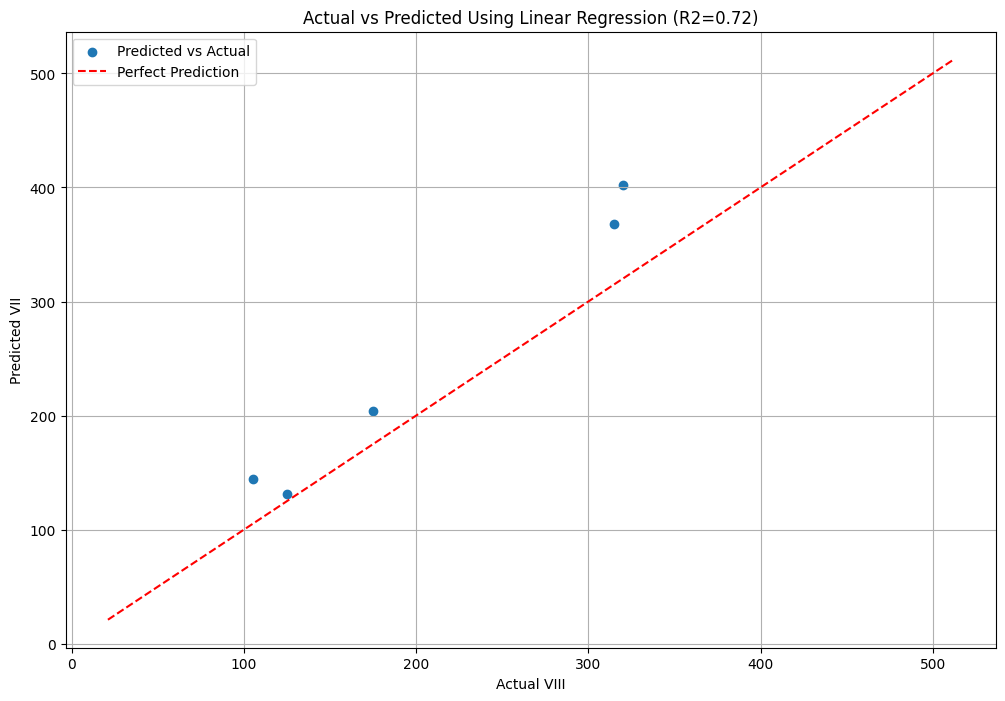

In [37]:
# Plot actual vs predicted values for our test set
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_test, y_pred, label='Predicted vs Actual')
ax.grid()
ax.set(title=f'Actual vs Predicted Using Linear Regression (R2={lr.score(X_test, y_test):.2f})', xlabel='Actual VIII', ylabel='Predicted VII')

# Plot a diagonal line showing what a “perfect” prediction would look like
min_val = min(min(y), min(y_pred))
max_val = max(max(y), max(y_pred))
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend();

Not particularly accurate looking.  Lets evaluate the model performance and see how we can improve accuracy.

## Evaluating the Model Performance

Initially lets evaluate the model performance using all the features available to us.

In [38]:
# Let's calculate the R^2
lr.score(X_test, y_test)

0.719156084893374

The model performs poorly at 72% when all the features are included.  Lets try removing the categorical variables and see if that helps the model accuracy.

In [39]:
# Setting everything up again excluding the categorical varibles
X = df.loc[:, ['societal_impact', 'societal_reach', 'time_to_impact', 'up_votes']].values
y = df.iloc[:, -1].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Let's calculate the R^2
lr.score(X_test, y_test)

0.9108738203259484

This time we get a strong R^2 score of 91%.  Lets try removing the up votes feature and see how that affects the model accuracy.

In [40]:
# Setting everything up again including the categorical varibles
X = df.loc[:, ['societal_impact', 'societal_reach', 'time_to_impact']].values
y = df.iloc[:, -1].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Let's calculate the R^2
lr.score(X_test, y_test)

0.9209181808074973

We get a slightly stronger R^2 score of 92% with just the continuous variables 'societal_impact', 'societal_reach', 'time_to_impact'.

Lets plot the actual vs predicted values again now that our model is more accurate.

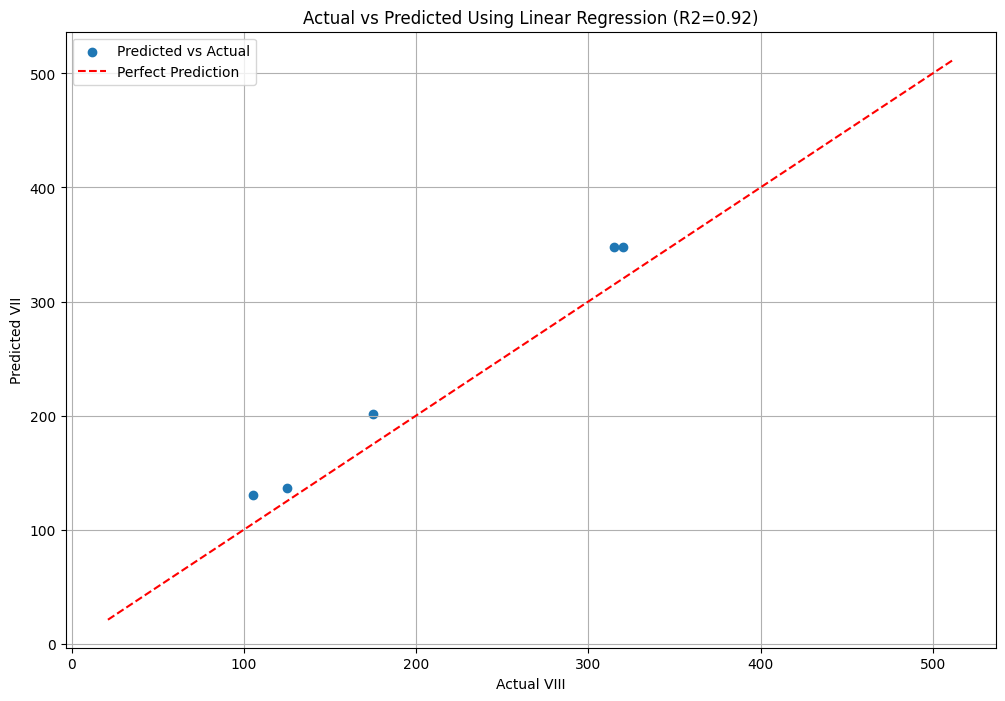

In [41]:
# Plot actual vs predicted values for our test set
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_test, y_pred, label='Predicted vs Actual')
ax.grid()
ax.set(title=f'Actual vs Predicted Using Linear Regression (R2={lr.score(X_test, y_test):.2f})', xlabel='Actual VIII', ylabel='Predicted VII')

# Plot a diagonal line showing what a “perfect” prediction would look like
min_val = min(min(y), min(y_pred))
max_val = max(max(y), max(y_pred))
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend();

## Examining the Residuals

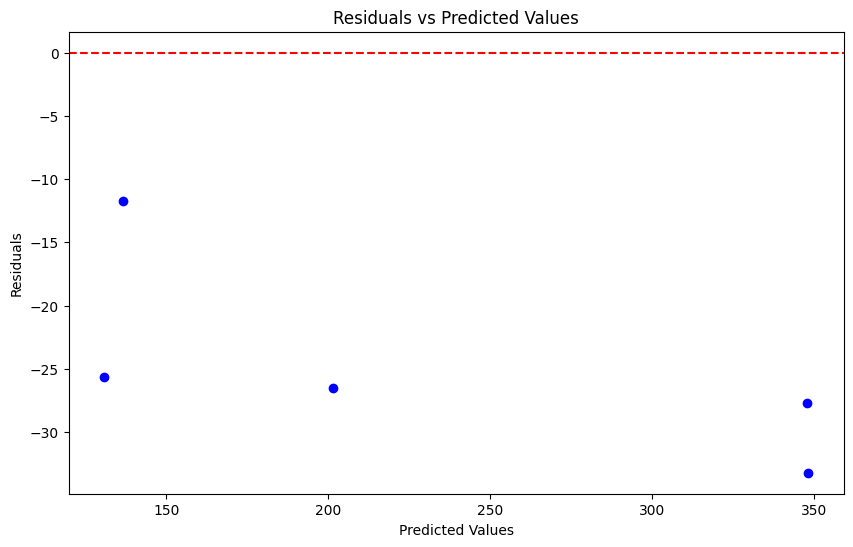

In [42]:
# Calculating residuals
residuals = np.array(y_test) - np.array(y_pred)

plt.figure(figsize=(10, 6))

# Plotting residuals
plt.scatter(y_pred, residuals, color='blue')

# Adding a horizontal line at y = 0
plt.axhline(y=0, color='red', linestyle='--')

# Adding labels and title
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

plt.show()

Residuals are simply the differences between the actual values and the predicted values.

## Finding the equation

In [43]:
lr.coef_

array([36.68, 32.4 , 33.65])

The slope for the first variable (societal impact) is 37.35, for the second variable (societal_reach) the coefficient is 31.37 and for the third variable (time_to_impact) the coefficient is 32.64. We'll return to these in a second, but first let's look at the y-intercept.

In [44]:
lr.intercept_

-376.9867040882006

So that means the line has the following formula:

In [46]:
print(f'viii = ({lr.coef_[0]:.2f} x societal_impact) + ({lr.coef_[1]:.2f} x societal_reach) + ({lr.coef_[2]:.2f} x time_to_impact) + {lr.intercept_}')

viii = (36.68 x societal_impact) + (32.40 x societal_reach) + (33.65 x time_to_impact) + -376.9867040882006


This makes perfect sense as we know the actual formula used to calculate the viii is VIII = societal impact x societal reach x time to impact.

In summary, we were able to predict the formula for calculating the VIII with approximately 92% accuracy using a linear regression model trained on the 25 records provided in the data set.  Additional data should only help improve the models accuracy.